In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.4.1


In [4]:
col_names=['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'tweet', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet']

In [8]:
df = pd.read_csv('gdrive/My Drive/Twitter_sentiment/input/vaccination_tweets.csv', names=col_names)
df.drop(index=0, inplace=True)

In [9]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,tweet,hashtags,source,retweets,favorites,is_retweet
1,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
2,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
3,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
4,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
5,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [10]:
!ls 'gdrive/My Drive/Twitter_sentiment/input/'

clean_covid_input.csv  Covid_Tweets_Predictions.csv
clean_covid_pred.csv   training.1600000.processed.noemoticon.csv
clean_input.csv        vaccination_tweets.csv


In [11]:
pred_df = pd.read_csv('gdrive/My Drive/Twitter_sentiment/input/Covid_Tweets_Predictions.csv')
# pred_df.drop('Unnamed: 0', axis=1, inplace=True)

In [22]:
pred_df.drop('Unnamed: 0', axis=1, inplace=True)

In [23]:
pred_df.head()


,tweet,prediction
0,folks say daikon paste could treat cytokine storm,0
1,world wrong side history year hopefully bigges...,0
2,russian vaccine create last years,0
3,facts immutable senator even ethically sturdy ...,1
4,e good lie need vaccine,0


In [24]:
df['label'] = pred_df['prediction']

In [25]:
df.dtypes

id                   object
user_name            object
user_location        object
user_description     object
user_created         object
user_followers       object
user_friends         object
user_favourites      object
user_verified        object
date                 object
tweet                object
hashtags             object
source               object
retweets             object
favorites            object
is_retweet           object
label               float64
dtype: object

In [26]:
df['retweets']=df.retweets.astype(float)
df['favorites']=df.favorites.astype(float)

In [27]:
df['user_verified']=df['user_verified'].apply(lambda x:'verified' if x==True else 'not_verified')
from datetime import date
df['today']=date.today()
df['user_created']=pd.to_datetime(df['user_created']).dt.year
df['today']=pd.to_datetime(df['today'])
df['today']=df['today'].dt.year
df['acc_age']= df['today']-df['user_created']
df['total_engagement']=df['retweets']+df['favorites']
df['tweet_lenght']=df['tweet'].apply(lambda x:len(x))
df['tweet_lenght'].describe()
df['tweet_length']=df['tweet'].apply(lambda x:'short' if len(x)<=130 else 'long')

In [28]:
df['date']=pd.to_datetime(df['date'])
L = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']
df = df.join(pd.concat((getattr(df['date'].dt, i).rename(i) for i in L), axis=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [29]:
loc_df = df['user_location'].str.split(',',expand=True)
loc_df=loc_df.rename(columns={0:'first_loc',1:'second_loc'})

# Remove Spaces 
loc_df['second_loc'] = loc_df['second_loc'].str.strip()
# Rename States 
state_fix = {'Ontario': 'Canada','United Arab Emirates': 'UAE','TX': 'USA','NY': 'USA'
                  ,'FL': 'USA','England': 'UK','Watford': 'UK','GA': 'USA','IL': 'USA'
                  ,'Alberta': 'Canada','WA': 'USA','NC': 'USA','British Columbia': 'Canada','MA': 'USA','ON':'Canada'
            ,'OH':'USA','MO':'USA','AZ':'USA','NJ':'USA','CA':'USA','DC':'USA','AB':'USA','PA':'USA','SC':'USA'
            ,'VA':'USA','TN':'USA','New York':'USA','Dubai':'UAE','CO':'USA'}
loc_df = loc_df.replace({"second_loc": state_fix}) 
loc_df['second_loc'].value_counts()[:20]

USA                863
UK                 540
Canada             186
India              178
Ireland             91
UAE                 77
United Kingdom      75
Germany             61
Belgium             26
France              24
South Africa        23
Scotland            22
Pakistan            19
Qatar               17
London              17
MI                  16
New South Wales     16
Malaysia            16
Deutschland         16
Australia           15
Name: second_loc, dtype: int64

In [30]:
df['Hash'] = df['tweet'].apply(lambda word:word.count('#'))

In [31]:
df['Men'] = df['tweet'].apply(lambda word:word.count('@'))


In [32]:
#('https://t.co/) this part in tweets refers to photos,videos
df['med'] = df['tweet'].apply(lambda word:word.count('https://t.co/'))
df['med'] = df['med'].apply(lambda x:'No Media' if x==0 else 'Media')

In [33]:
df['user_followers'].value_counts()

2        52
1        44
106      41
0        38
6        36
         ..
40927     1
2073      1
86248     1
32583     1
6722      1
Name: user_followers, Length: 2991, dtype: int64

In [34]:
df['acc_class'] = df['user_followers'].apply(lambda x:'weak'if int(x)<=100 else ('norm' if 1000>=int(x)>100 else ('strong' if 10000>=int(x)>1000 else 'influencer')))
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,tweet,hashtags,source,retweets,favorites,is_retweet,label,today,acc_age,total_engagement,tweet_lenght,tweet_length,year,month,day,dayofweek,dayofyear,weekofyear,quarter,Hash,Men,med,acc_class
1,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009,405,1692,3247,not_verified,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0.0,0.0,False,0.0,2021,12,0.0,97,short,2020,12,20,6,355,51,4,1,0,Media,norm
2,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009,834,666,178,not_verified,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1.0,1.0,False,0.0,2021,12,2.0,140,long,2020,12,13,6,348,50,4,0,0,Media,norm
3,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020,10,88,155,not_verified,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0.0,0.0,False,1.0,2021,1,0.0,140,long,2020,12,12,5,347,50,4,6,0,Media,weak
4,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008,49165,3933,21853,not_verified,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446.0,2129.0,False,0.0,2021,13,2575.0,140,long,2020,12,12,5,347,50,4,0,0,Media,influencer
5,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020,152,580,1473,not_verified,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0.0,0.0,False,0.0,2021,1,0.0,135,long,2020,12,12,5,347,50,4,2,2,Media,norm


In [35]:
df=df[['user_name','tweet','date', 'acc_age','user_verified','retweets','favorites','total_engagement', 'day', 'tweet_length',
       'Hash', 'Men', 'med', 'acc_class','month','label']]
df_copy=df.copy()

In [36]:
df.head()

,user_name,tweet,date,acc_age,user_verified,retweets,favorites,total_engagement,day,tweet_length,Hash,Men,med,acc_class,month,label
1,Rachel Roh,Same folks said daikon paste could treat a cyt...,2020-12-20 06:06:44,12,not_verified,0.0,0.0,0.0,20,short,1,0,Media,norm,12,0.0
2,Albert Fong,While the world has been on the wrong side of ...,2020-12-13 16:27:13,12,not_verified,1.0,1.0,2.0,13,long,0,0,Media,norm,12,0.0
3,eli🇱🇹🇪🇺👌,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,2020-12-12 20:33:45,1,not_verified,0.0,0.0,0.0,12,long,6,0,Media,weak,12,1.0
4,Charles Adler,"Facts are immutable, Senator, even when you're...",2020-12-12 20:23:59,13,not_verified,446.0,2129.0,2575.0,12,long,0,0,Media,influencer,12,0.0
5,Citizen News Channel,Explain to me again why we need a vaccine @Bor...,2020-12-12 20:17:19,1,not_verified,0.0,0.0,0.0,12,long,2,2,Media,norm,12,0.0


In [37]:
df.dtypes


user_name                   object
tweet                       object
date                datetime64[ns]
acc_age                      int64
user_verified               object
retweets                   float64
favorites                  float64
total_engagement           float64
day                          int64
tweet_length                object
Hash                         int64
Men                          int64
med                         object
acc_class                   object
month                        int64
label                      float64
dtype: object

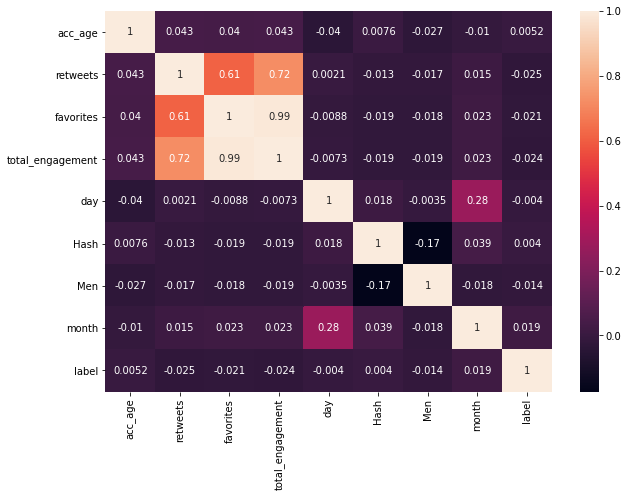

In [38]:
corr=df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr,annot=True)

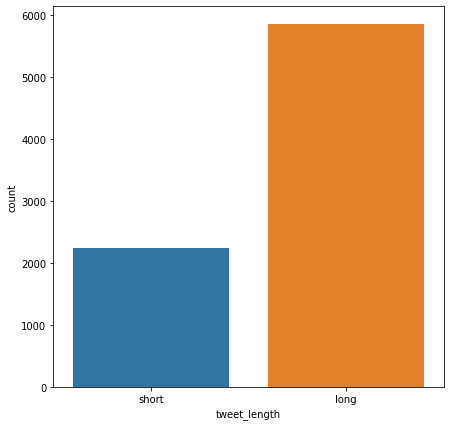

In [39]:
plt.figure(figsize=(7,7))
sns.countplot(x='tweet_length',data=df);

(-1.1505029161234455,
 1.0574951215706034,
 -1.2009314800414903,
 1.1048062907740432)

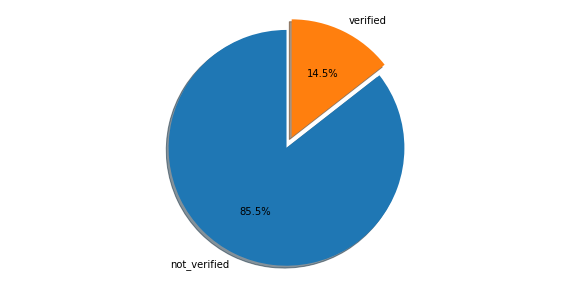

In [40]:
labels = 'not_verified', 'verified'
sizes = [1888, 319]
explode = (0.1, 0)  
plt.figure(figsize=(10,5))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90);
plt.axis('equal')

In [41]:
class_eng = df.groupby('acc_class',as_index=False).agg({'total_engagement':'sum',})


In [42]:
fig = px.bar(class_eng,
             x='acc_class',
             y='total_engagement',
             color='total_engagement',
             color_continuous_scale='Rainbow',
             title='Engagement By Account_Class')
fig.show()

In [43]:
Media = len(df[df['med']=='Media'])
No_Media = len(df[df['med']=='No Media'])
Platform = ['Media','No Media']
Count = [Media,No_Media]
#====
fig = px.pie(names = Platform,
             values = Count,
             title='Media/No Media',
            color_discrete_sequence = px.colors.sequential.Rainbow)
fig.update_traces(textposition='inside', textinfo='percent+label')

In [44]:
line = df.groupby('date',as_index=False).agg({'total_engagement':'sum'})
fig = go.Figure()
fig.add_trace(go.Scatter(x=line.date, y=line.total_engagement,
                    mode='lines+markers'))

In [45]:
december=df.loc[df['month']==12]
day_december = december.groupby('day',as_index=False).agg({'total_engagement':'sum'})

fig = px.scatter(day_december,
                 x='day',
                 y='total_engagement',
                 color_continuous_scale='Rainbow',
                 color='total_engagement',
                 size='total_engagement',
                 title='Most engaged days in December')
fig.show()

In [46]:
january=df.loc[df['month']==1]
day_january = january.groupby('day',as_index=False).agg({'total_engagement':'sum'})

fig = px.scatter(day_january,
                 x='day',
                 y='total_engagement',
                 color_continuous_scale='Rainbow',
                 color='total_engagement',
                 size='total_engagement',
                 title='Most engaged days in january')
fig.show()

In [47]:
df3=pd.DataFrame(loc_df['second_loc'].value_counts()[:20]).reset_index()
df3

,index,second_loc
0,USA,863
1,UK,540
2,Canada,186
3,India,178
4,Ireland,91
5,UAE,77
6,United Kingdom,75
7,Germany,61
8,Belgium,26
9,France,24


In [48]:
fig = px.choropleth(df3, locations = df3['index'],
                    color = df3['second_loc'],locationmode='country names',hover_name = df3['second_loc'], 
                    color_continuous_scale = px.colors.sequential.Inferno)
fig.update_layout(title='Tweets By Region')
fig.show()

In [49]:

Negative = len(df[df['label']==0])
Positive = len(df[df['label']==1])
labels = ['Negative','Positive']
values = [Negative,Positive]

import plotly.graph_objects as go
colors = ['red','green' ]

fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,textposition='inside',
                  marker=dict(colors=colors, line=dict(color='grey', width=1)))
fig.show()